In [1]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import utils  # some helper functions I created

from warnings import filterwarnings
filterwarnings('ignore')

% config InlineBackend.figure_format = 'retina'

Beginning by observing the state of the data (e.g shape, columns, column types, null values etc)

In [2]:
raw_data = pd.read_csv('device_failure_data_scientist.csv')
print(raw_data.shape)
list(raw_data.columns)

(124494, 12)


['date',
 'device',
 'attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9',
 'failure']

In [3]:
raw_data.sample(5)

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
117473,15246,Z1F0GB8A,152987816,0,0,0,7,312279,0,0,0,0
78005,15125,W1F0M02P,190540880,0,1,6,10,483300,0,0,33,0
116158,15239,S1F11K34,49187184,0,0,0,16,369742,0,0,0,0
19082,15023,W1F0ZJK8,180795368,0,0,0,8,210174,0,0,0,0
96746,15177,Z1F0LSQ4,50656056,0,0,0,7,331999,0,0,0,0


Let's see which devices are emmitting failed states and non-failed states and compare!

In [4]:
from collections import Counter

failed_devices = raw_data[raw_data.failure == 1].device
failed_counts = Counter(failed_devices) 
print('There are a total of {} failed devices with {} of them unique'.format(len(failed_devices), len(failed_counts)))

non_failed_devices = raw_data[raw_data.failure == 0].device
non_failed_counts = Counter(non_failed_devices)
print('There are a total of {} non-failed devices with {} of them unique'.format(len(non_failed_devices), len(non_failed_counts)))

common_device_states = set(failed_devices) & set(non_failed_devices)
print('There are {} devices that have emmitted non-failed and failed states'.format(len(common_device_states)))

There are a total of 106 failed devices with 106 of them unique
There are a total of 124388 non-failed devices with 1168 of them unique
There are 106 devices that have emmitted non-failed and failed states


Each failed device is unique! On the other hand, we have devices that have multiple samples of their healthy states. Because we have 106 unique failed devices and the intersection between `failed_devices` and `non_failed_devices` is also 106 - this means that each failed state that we have observed has a matching healthy state in the dataset. (e.g every failed device also has a non-failed state in the dataset).

In [5]:
label_counts = pd.value_counts(raw_data.failure)
print('approximately {:0.4f}% of data has a failed state'.format(100 * label_counts.iloc[1] / label_counts.iloc[0]))

label_counts

approximately 0.0852% of data has a failed state


0    124388
1       106
Name: failure, dtype: int64

The data set is highly imbalanced, less than 1% of the data has the positive class which we wish to detect. When building the predictive model we may resort to model metrics such as precision and recall to see how well our model is able to detect failed states. Accuracy in this case will be very misleading. This is because we can predict each sample as non-failed and we will obtain 99% accuracy! This is misleading because we would have not accurately predicted failed states (e.g 1).

As seen below, none of the devices have `NaN` values.

In [6]:
pd.isna(raw_data).sum()

date          0
device        0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
failure       0
dtype: int64

Number of zeros in each column: 

In [7]:
(raw_data == 0).sum(axis=0)

date               0
device             0
attribute1        11
attribute2    118110
attribute3    115359
attribute4    115156
attribute5         0
attribute6         0
attribute7    123036
attribute8    123036
attribute9     97358
failure       124388
dtype: int64

Some of our features contain a significant amount of zeros. This is good to take into consideration early, because we may need to determine if these features will actually be useful. More later. 

Type checks:

In [8]:
raw_data.dtypes

date           int64
device        object
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
failure        int64
dtype: object

## Data Prep

In [9]:
features = raw_data.columns[2:-1].tolist()  

X = raw_data[features] # features
y = raw_data.failure # labels

We can get a high level view of the original features in the dataset below:

In [10]:
feature_describe_df = pd.DataFrame(X, columns=features).describe()
feature_describe_df

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


When scaling features to have zero mean and standard deviation 1 for training, it is important to note that the scaler should be fit on the training data. Then using the fitted scaler on the training data we transform the testing data independently in order to prevent leakage of test set knowledge into the training set. The wrong approach would be to scale all of our data, then to split into train/test sets. Instead, we split the data into train/test sets and then scale independetly using training set mean and standard deviations of features for the test set. 

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # 70/30 train test split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # mean 0, std 1
X_test_scaled = scaler.transform(X_test)

print('train shape: {}'.format(X_train.shape))
print('test shape: {}\n'.format(X_test.shape))

train_positive = pd.value_counts(y_train)
test_positive = pd.value_counts(y_test)

print('training\n', train_positive, '\n')
print('testing\n', test_positive, '\n')

print('{:0.4f}% are failed states in training'.format(100 * train_positive.iloc[1] / train_positive.iloc[0]))
print('{:0.4f}% are failed states in testing'.format(100 * test_positive.iloc[1] / test_positive.iloc[0]))

train shape: (87145, 9)
test shape: (37349, 9)

training
 0    87065
1       80
Name: failure, dtype: int64 

testing
 0    37323
1       26
Name: failure, dtype: int64 

0.0919% are failed states in training
0.0697% are failed states in testing


## Building a Predictive Model

Approach:

Begin by building a simple predictive model with little to no feature engineering besides feature scaling. The first predictive model I build is a Logistic Regression model. This model will give us prediction probabilities of the data being a member of the `failure` class. Obtaining these probabilities of failed states can help us understand how varying the threshold in the classifier can improve on minimizing false positive and false negative predictions. We can check this with both `ROC Curve` and `Precision-Recall Curve`. We can then quickly implement other models for comparison (e.g boosted trees, one-class SVM) using the same approach.

## Logistic Regression

This logistic regression model is built off a cross validation strategy for finding the best hyperparameters (e.g Cs - the inverse regularization strengths). The parameters were chosen to take into consideration the highly imbalanced class labels in the dataset. These parameters include:

* class-weight='balanced': 

This will make the model more aware of the class imbalance by incorporating a higher cost to the objective function for the minority class. 

* scoring='precision':

This is the scoring function that is used to evaluate each model trainined during the cross validation procedure. Because our class is highly imbalanced, the default accuracy function will be very misleading to measure the quality of our model. Precsion will yield more accurate representations of our model quality because we are more interested in how well our model predicts the positive class (e.g failed states).

In [12]:
from sklearn.linear_model import LogisticRegression

# parameter space
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [75, 100, 150, 200, 500],
} 

n_iter = 10
folds = 2
lr = LogisticRegression(penalty='l1',
                        solver='saga',
                        class_weight='balanced',
                        random_state=1101)

skf = StratifiedKFold(n_splits=folds, shuffle=True)
lr_search = RandomizedSearchCV(lr,
                               param_distributions=params,
                               n_iter=n_iter,
                               scoring='precision',
                               n_jobs=4,
                               cv=skf.split(X_train_scaled,y_train),
                               verbose=1)

lr_search.fit(X_train_scaled, y_train)

print('\n Best estimator:')
print(lr_search.best_estimator_)
print('\n Best hyperparameters:')
print(lr_search.best_params_)

y_pred = lr_search.predict(X_test_scaled)
utils.model_validation(y_test, y_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.6s finished



 Best estimator:
LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1101, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

 Best hyperparameters:
{'max_iter': 500, 'C': 0.001}
confusion matrix
[[36306  1017]
 [   13    13]] 

precision: 0.01262135922330097
recall: 0.5
accuracy: 0.9724222870759592


This model is able to accurately detect 12 out of the 20 samples that are labeled as `failure` within the test set. For the interest of time, this model may be improved by peforming a more fine-grained gridsearch over a different parameter space in hopes of increasing precision and recall scores. The final parameters for this model are:

In [13]:
lr_search.best_estimator_.get_params()

{'C': 0.001,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 1101,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
list(lr_search.best_estimator_.coef_.flatten()) # model coefficients

[-0.091515169714914135,
 0.37948977586287197,
 0.0,
 0.58055204749337586,
 0.054444862780924287,
 0.0,
 0.42659070844360902,
 0.42659070844360902,
 0.017300715523880093]

Some of our model weights have been driven down to zero. This is because we are applying the `L1` penalty to our objective function. It is reducing the complexity of our model by penalizing large weights and essentially driving some features down to zero (e.g acting like a feature selector!). Using `L2` penalty also drives weights are driven to zero but not exacly zero. 

Using `L1` as a feature selector appears to be useful for us in this case. This may be because, as noted earlier, some of the features contain mostly zeros. Removing some of the columns appear to yeild better predictive power as we are able to reduce some of the fase positives and false negatives. 

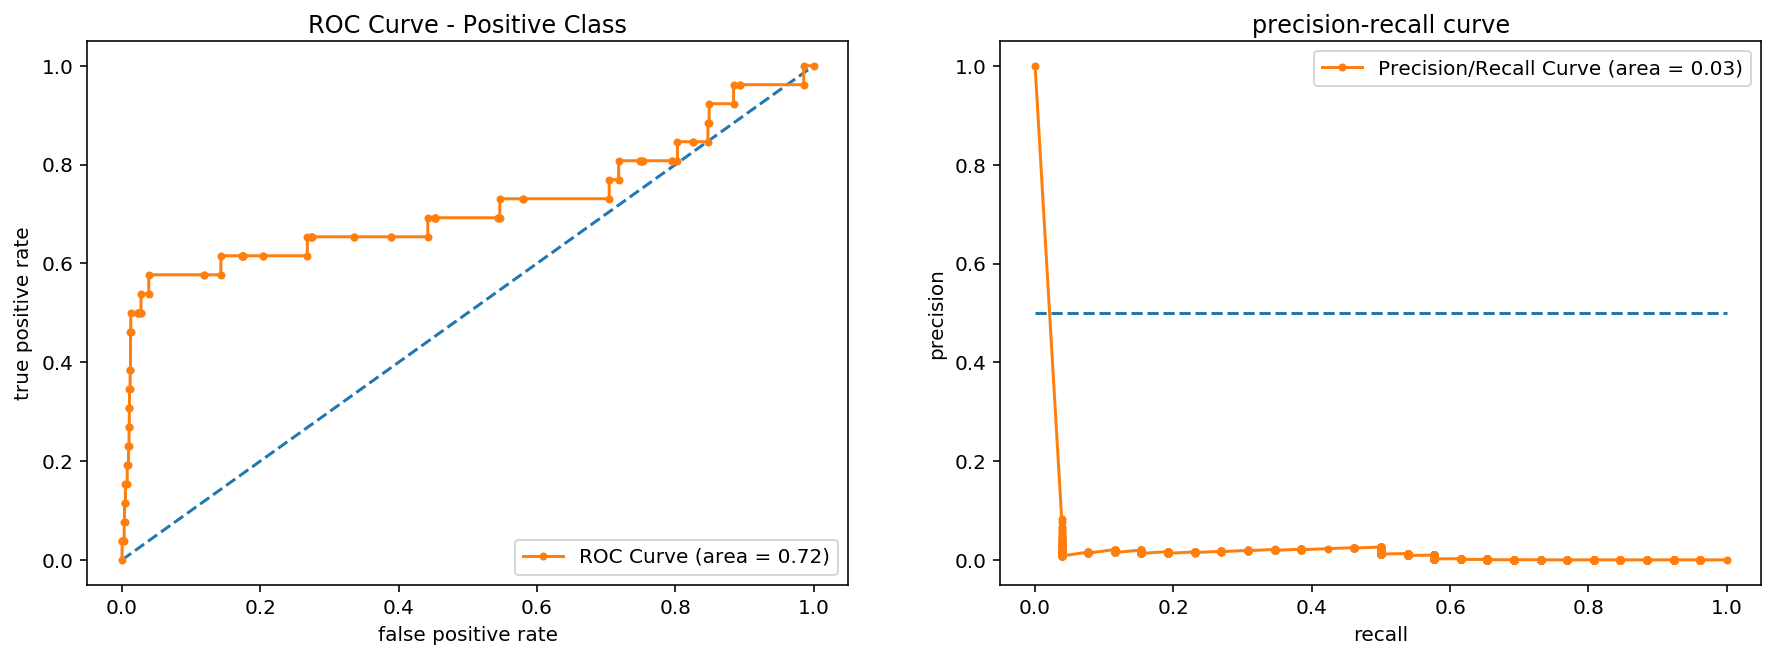

In [15]:
utils.plot_model_curves(lr_search.best_estimator_, X_test_scaled, y_test) # logistic regression model

In [16]:
utils.get_performance_measure(y_test.values, y_pred)

True Positives  13
False Positives  1017
True Negatives  36306
False Negatives  13


The ROC curve is misleading because of the highly imbalanced classes, the precision-recall curve over different thresholds gives us a more detailed view of the poor performance of the model in detecting the positive class (e.g failure).

## XGBOOST


Boosting trees may be a good alternative to try on this highly imbalanced dataset because of iterative training process on previous model errors. This model was designed to showcase model performance in comparison to the logistic regression model.

Approach:

Perform a randomized search over a parameter space instead of an exhuastive search (to save time). Training is done on original features without any scaling.

In [21]:
import xgboost as xgb

folds = 2
n_iter = 3 # number of param configurations to test

# parameter space
params = {
    'max_depth': [2, 4, 6, 10],
    'learn_rate': [ 0.025, 0.1, 0.25, 0.3],
    'min_child_weight': [1, 5, 10],
    'max_delta_step': [1, 2, 6, 10],
    'gamma': [0.1, 0.5, 1, 1.5, 2],
    'n_estimators': [500, 1000, 1500],
} 

# scaling for the minority class emphasis
ratio = len(raw_data[raw_data.failure == 0]) / len(raw_data[raw_data.failure == 1])

xgb = xgb.XGBClassifier(eval_metric='aucpr',
                        scale_pos_weight=ratio,
                        objective='binary:logistic')

skf = StratifiedKFold(n_splits=folds, shuffle=True)
boosted_trees = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=n_iter,
                                   scoring='recall',
                                   n_jobs=4,
                                   cv=skf.split(X_train,y_train),
                                   verbose=1)

boosted_trees.fit(X_train, y_train)

print('\n Best estimator:')
print(boosted_trees.best_estimator_)
print('\n Best hyperparameters:')
print(boosted_trees.best_params_)

results = pd.DataFrame(boosted_trees.cv_results_)
y_pred = boosted_trees.predict(X_test)
utils.model_validation(y_test, y_pred)
utils.get_performance_measure(y_test.values, y_pred)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  1.7min finished



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=2, learn_rate=0.25, learning_rate=0.1, max_delta_step=2,
              max_depth=2, min_child_weight=5, missing=None, n_estimators=500,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1173.4716981132076, seed=None, silent=None,
              subsample=1, verbosity=1)

 Best hyperparameters:
{'max_depth': 2, 'learn_rate': 0.25, 'max_delta_step': 2, 'min_child_weight': 5, 'gamma': 2, 'n_estimators': 500}
confusion matrix
[[36415   908]
 [   19     7]] 

precision: 0.007650273224043716
recall: 0.2692307692307692
accuracy: 0.9751800583683633
True Positives  7
False Positives  908
True Negatives  36415
False Negatives  19


True Positives  7
False Positives  908
True Negatives  36415
False Negatives  19


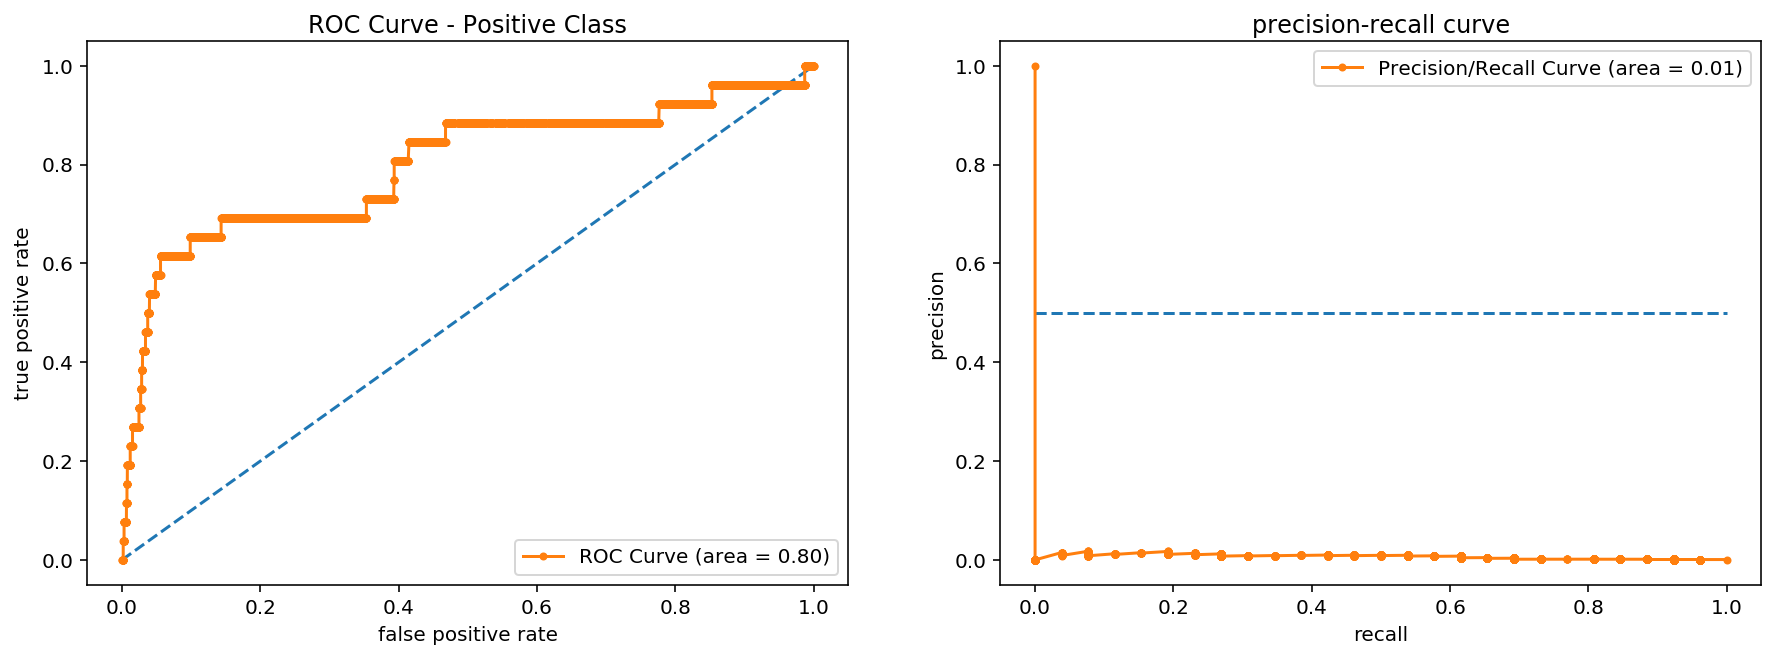

In [22]:
utils.get_performance_measure(y_test.values, y_pred)
utils.plot_model_curves(boosted_trees.best_estimator_, X_test, y_test) # boosted trees model

This model is also very poor in its performance on the raw features. I would resort to logistic regression at this point, if we don't consider any additional feature engineering other than scaling them to mean 0 and std 1. 

## One-Class SVM

Another approach that we can take is modeling only healthy states. During training, only `non-failed` states are presented to the model. Then during test time, both `failed` and `non-failed` states are sent to the model and our precision and recall metrics can be tested on these results. 

Training and Testing process:

* create training set on 70% of the `non-failure` instances.

* create testing set on remaining 30% of `non-failure` instances and all of the `failed` instances.

We can then use these training and testing sets on the One-Class SVM model. The One-Class SVM model may be of benifit for modeling `failed` and `non-failed` states, by using kernel methods. These kernel methods may provide a better discriminator to our minority class. 

train shape: (87071, 9)
test shape: (37423, 9)

[LibSVM]confusion matrix
[[18591 18726]
 [   75    31]] 

precision: 0.0016527163192408168
recall: 0.29245283018867924
accuracy: 0.49760842262779575


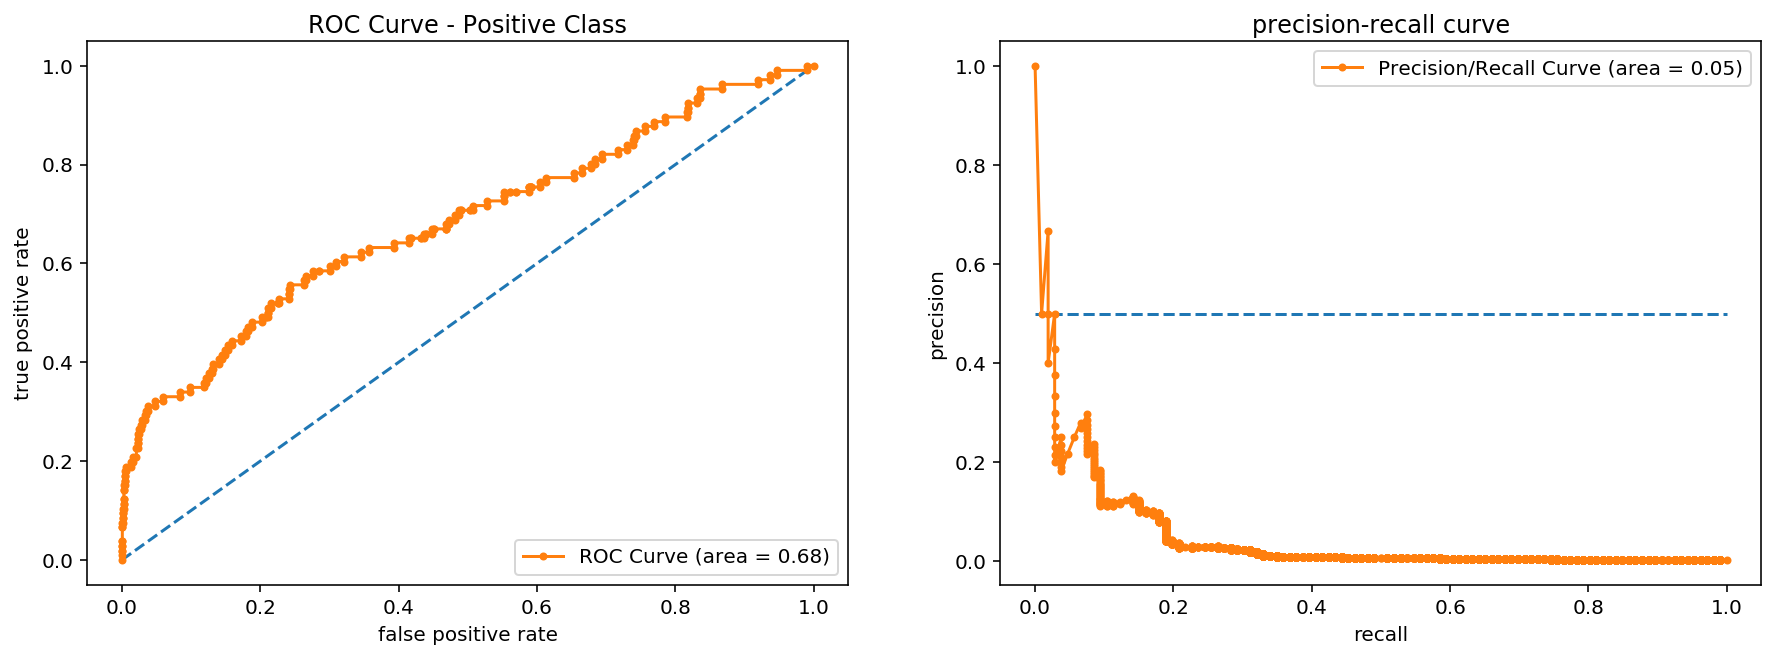

In [24]:
from sklearn.svm import OneClassSVM

normal = raw_data[raw_data.failure == 0]
normal = normal.sample(frac=1) # shuffle data before split
abnormal = raw_data[raw_data.failure == 1]

# Train with the first 75% of the normal instances
X_train = normal.iloc[:int(len(normal)*0.70)][features] 
y_train = np.array([0] * len(X_train))

# Test with the last 25% of normal instances AND all the abnormal samples
X_test = pd.concat([normal.iloc[int(len(normal)*0.70):], abnormal])
y_test = X_test.failure
X_test = X_test[features]

print('train shape: {}'.format(X_train.shape))
print('test shape: {}\n'.format(X_test.shape))

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)  # mean 0, std 1
X_scaled_test = scaler.transform(X_test)

clf = OneClassSVM(kernel='poly',
                  degree=2,
                  verbose=1).fit(X_scaled_train)
y_pred = clf.predict(X_scaled_test)
y_pred = [0 if val == 1 else 1 for val in y_pred] # post processing

utils.model_validation(y_test, y_pred)
utils.plot_model_curves(clf, X_scaled_test, y_test, decision_func=True)

The threshold that appears to give us the best precision and recall scores apear to be > 0.1. This will give us a higher recall score but at a cost to the model precision.

In [26]:
# thresholded predictions based off PR-Curve
probs = clf.decision_function(X_scaled_test)

y_thresh = np.where(probs > 0.1, 1, 0)
utils.model_validation(y_test, y_thresh)

confusion matrix
[[18734 18583]
 [   31    75]] 

precision: 0.0040197234430271195
recall: 0.7075471698113207
accuracy: 0.502605349651284


We obtain a much better recall score using the OneclassSVM, with a huge cost to our precision score and overall accuracy. More fine tuning will be needed in this case. 

## Some Remarks

This notebook is intendend to showcase some approaches to modeling this highly imbalanced dataset, and by no means are considered complete. This can be considered as a framework to test different models with some new feature engineered features. Of course, a more careful approach to parameter setting/tuning will be needed but for the sake of time it was not focused on heavily. Instead, I tested some different approaches to modeling the data as is. Some remaining experiments that we can carry out may include the following:

* upsampling minority class - This may increase our precision and recall scores and allow us to better identify `failed` states for the devices. As a result, precision and recall may improve.

* feature engineering/feature selection - A more careful approach to feature engineering and selection may be applied. (e.g forward/backward selection, generating new features from existing features)

* fine grainded grid search - A more fine-grained grid search of the parameter space may be used and choose models that increase our precsion and recall scores. 

These steps may be applied to the models tested above. We can also try creating differenet models. Isolation forests is something that I would like to try next. A deep learning approach can also be used (e.g Auto-encoders) which are commonly used for anomaly detection, by only modeling healthy states. 